23.jpg
262.07036865234375
54.jpg
-140.22992431640625
51.jpg
565.52810546875
159.jpg
692.3018933105469
58.jpg
423.0628503417969
171.jpg
789.0974475097655
4.jpg
461.87755065917963
19.jpg
256.8152032470703
79.jpg
259.3636804199219
125.jpg
656.5006921386719
74.jpg
262.80436279296873
87.jpg
435.217880859375
150.jpg
15.876708984375
28.jpg
142.01395751953123
56.jpg
113.9011926269531
3.jpg
403.1710375976562
40.jpg
341.7634661865235
2.jpg
711.8983007812501
134.jpg
267.77884399414063
8.jpg
-406.55559570312505
99.jpg
88.83890808105468
180.jpg
107.19581420898436
59.jpg
257.9401745605469
103.jpg
401.68402221679685
25.jpg
233.79964355468752
21.jpg
157.83861328125
114.jpg
471.6031359863281
110.jpg
-44.559094238281205
175.jpg
150.9412744140625
141.jpg
105.19283935546878
78.jpg
486.5364819335938
70.jpg
261.06659057617185
133.jpg
323.0836608886719
92.jpg
702.1783544921873
152.jpg
570.5496008300781
97.jpg
747.576875
80.jpg
385.4692730712891
117.jpg
582.39794921875
170.jpg
810.3233789062499
35.jpg
-12.432

KeyboardInterrupt: 

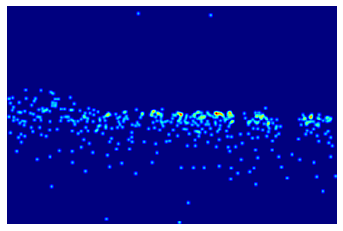

In [4]:
from matplotlib import pyplot as plt

import matplotlib
import os
import random
import torch
from torch.autograd import Variable
import torchvision.transforms as standard_transforms
import misc.transforms as own_transforms
import pandas as pd

from models.CC import CrowdCounter
from config import cfg
from misc.utils import *
import scipy.io as sio
from PIL import Image, ImageOps

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

exp_name = '../SHHA_results'
if not os.path.exists(exp_name):
    os.mkdir(exp_name)

if not os.path.exists(exp_name+'/pred'):
    os.mkdir(exp_name+'/pred')

if not os.path.exists(exp_name+'/gt'):
    os.mkdir(exp_name+'/gt')

mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])
img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
restore = standard_transforms.Compose([
        own_transforms.DeNormalize(*mean_std),
        standard_transforms.ToPILImage()
    ])
pil_to_tensor = standard_transforms.ToTensor()

dataRoot = '../ProcessedData/shanghaitech_part_A/test'

model_path = 'my_model_weigths.pth'

def main():
    
    file_list = [filename for root,dirs,filename in os.walk(dataRoot+'/img/')]                                           

    test(file_list[0], model_path)
   

def test(file_list, model_path):

    net = CrowdCounter(cfg.GPU_ID,cfg.NET)
    net.load_state_dict(torch.load(model_path))
    net.cuda()
    net.eval()


    f1 = plt.figure(1)

    gts = []
    preds = []

    for filename in file_list:
        print( filename )
        imgname = dataRoot + '/img/' + filename
        filename_no_ext = filename.split('.')[0]

        denname = dataRoot + '/den/' + filename_no_ext + '.csv'

        den = pd.read_csv(denname, sep=',',header=None).values
        den = den.astype(np.float32, copy=False)

        img = Image.open(imgname)

        if img.mode == 'L':
            img = img.convert('RGB')


        img = img_transform(img)

        gt = np.sum(den)
        with torch.no_grad():
            img = Variable(img[None,:,:,:]).cuda()
            pred_map = net.test_forward(img)

        sio.savemat(exp_name+'/pred/'+filename_no_ext+'.mat',{'data':pred_map.squeeze().cpu().numpy()/100.})
        sio.savemat(exp_name+'/gt/'+filename_no_ext+'.mat',{'data':den})

        pred_map = pred_map.cpu().data.numpy()[0,0,:,:]


        pred = np.sum(pred_map)/100.0
        pred_map = pred_map/np.max(pred_map+1e-20)
        
        den = den/np.max(den+1e-20)
        
        print(pred - gt)

        
        den_frame = plt.gca()
        plt.imshow(den, 'jet')
        den_frame.axes.get_yaxis().set_visible(False)
        den_frame.axes.get_xaxis().set_visible(False)
        den_frame.spines['top'].set_visible(False) 
        den_frame.spines['bottom'].set_visible(False) 
        den_frame.spines['left'].set_visible(False) 
        den_frame.spines['right'].set_visible(False) 
        plt.savefig(exp_name+'/'+filename_no_ext+'_gt_'+str(int(gt))+'.png',\
            bbox_inches='tight',pad_inches=0,dpi=150)

        plt.close()
        
        # sio.savemat(exp_name+'/'+filename_no_ext+'_gt_'+str(int(gt))+'.mat',{'data':den})

        pred_frame = plt.gca()
        plt.imshow(pred_map, 'jet')
        pred_frame.axes.get_yaxis().set_visible(False)
        pred_frame.axes.get_xaxis().set_visible(False)
        pred_frame.spines['top'].set_visible(False) 
        pred_frame.spines['bottom'].set_visible(False) 
        pred_frame.spines['left'].set_visible(False) 
        pred_frame.spines['right'].set_visible(False) 
        plt.savefig(exp_name+'/'+filename_no_ext+'_pred_'+str(float(pred))+'.png',\
            bbox_inches='tight',pad_inches=0,dpi=150)

        plt.close()

        # sio.savemat(exp_name+'/'+filename_no_ext+'_pred_'+str(float(pred))+'.mat',{'data':pred_map})

        diff = den-pred_map

        diff_frame = plt.gca()
        plt.imshow(diff, 'jet')
        plt.colorbar()
        diff_frame.axes.get_yaxis().set_visible(False)
        diff_frame.axes.get_xaxis().set_visible(False)
        diff_frame.spines['top'].set_visible(False) 
        diff_frame.spines['bottom'].set_visible(False) 
        diff_frame.spines['left'].set_visible(False) 
        diff_frame.spines['right'].set_visible(False) 
        plt.savefig(exp_name+'/'+filename_no_ext+'_diff.png',\
            bbox_inches='tight',pad_inches=0,dpi=150)

        plt.close()

        # sio.savemat(exp_name+'/'+filename_no_ext+'_diff.mat',{'data':diff})
                     



if __name__ == '__main__':
    main()



NameError: name 'filename_no_ext' is not defined